Code to replicate sequence-to-sequence architecture

In [3]:
# https://github.com/pytorch/text/blob/master/test/translation.py
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# https://graviraja.github.io/seqtoseqimp/#
# https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import re
import spacy

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [8]:
# https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab
# https://spacy.io/usage/models

!pip install de_core_news_sm

In [9]:
import de_core_news_sm
spacy_de = de_core_news_sm.load()

In [10]:
!pip install en_core_web_sm

In [11]:
import en_core_web_sm
spacy_en = en_core_web_sm.load()

In [12]:
url = re.compile('(<url>.*</url>)')

In [13]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(url.sub('@URL@', text))]


def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]

In [15]:
from torchtext.data.utils import get_tokenizer

DE = data.Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>')
EN = data.Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>')

In [16]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/data/data/translation/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=('.de', '.en'), fields=(DE, EN))
print('Loaded data...')

Loaded data...


In [51]:
# Code to reverse the input to feed to the network
'''
for i in range(len(train_data)):
    train_data[i].src = train_data[i].src[::-1]
for i in range(len(valid_data)):
    valid_data[i].src = valid_data[i].src[::-1]
'''

'\nfor i in range(len(train_data)):\n    train_data[i].src = train_data[i].src[::-1]\nfor i in range(len(valid_data)):\n    valid_data[i].src = valid_data[i].src[::-1]\n'

In [52]:
print(train_data.fields)
print(len(train_data))
print(len(valid_data))
print(vars(train_data[0]))
print(vars(train_data[100]))
print(vars(valid_data[100]))

{'src': <torchtext.data.field.Field object at 0x7fb266d6e518>, 'trg': <torchtext.data.field.Field object at 0x7fb3099afd68>}
29000
1014
{'src': ['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.'], 'trg': ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['Männliches', 'Kleinkind', 'in', 'einem', 'roten', 'Hut', ',', 'das', 'sich', 'an', 'einem', 'Geländer', 'festhält', '.'], 'trg': ['Toddler', 'boy', 'in', 'a', 'red', 'hat', 'holding', 'on', 'to', 'some', 'railings', '.']}
{'src': ['Ein', 'älterer', ',', 'übergewichtiger', 'Mann', 'wendet', 'einen', 'Pfannkuchen', ',', 'während', 'er', 'Frühstück', 'macht', '.'], 'trg': ['An', 'older', ',', 'overweight', 'man', 'flips', 'a', 'pancake', 'while', 'making', 'breakfast', '.']}


In [53]:
# set source and target language
DE.build_vocab(train_data.src, min_freq=3)
EN.build_vocab(train_data.trg, min_freq=3)

In [54]:
train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, device=device)

print(DE.vocab.freqs.most_common(10))
print(len(DE.vocab))
print(EN.vocab.freqs.most_common(10))
print(len(EN.vocab))

[('.', 28821), ('Ein', 13904), ('einem', 13697), ('in', 11830), (',', 8938), ('und', 8925), ('mit', 8838), ('auf', 8686), ('Mann', 7805), ('einer', 6750)]
5500
[('a', 31707), ('.', 27623), ('A', 17458), ('in', 14847), ('the', 9923), ('on', 8019), ('is', 7524), ('and', 7378), ('man', 7359), ('of', 6871)]
4727


In [55]:
batch = next(iter(train_iter))
print(batch.src.size())
#print(batch.src[-1])
#print(batch.src.size())
#print(batch.trg.size())

torch.Size([23, 32])


In [56]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, device):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)

        self.device = device
        self.to(self.device)
        
    def forward(self, input, hidden):
        # input is of shape [sentence_length, batch_size]
        # embedded is of shape [sentence_length, batch_size, embedding_size]

        input = input.to(self.device)

        embedded = self.embed(input)
        output, hidden = self.gru(embedded, hidden)

        # output shape is [sentence_length, batch_size, hidden_dim]
        # hidden shape is [num_layers, batch_size, hidden_dim]

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [57]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, device):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.device = device
        self.to(self.device)

    def forward(self, input, hidden):
        # input is of shape [batch_size]
        
        input = input.unsqueeze(0)
        # now, input shape is [1, batch_size]

        input = input.to(self.device)

        embedded = self.embed(input)
        # embedded is of shape [1, batch_size, embedding_dim]

        embedded = F.relu(embedded)
        output, hidden = self.gru(embedded, hidden)

        output = self.out(output.squeeze(0))
        output = self.softmax(output)

        return output, hidden


In [58]:
vocab_size_src = len(DE.vocab)
vocab_size_trg = len(EN.vocab)

embedding_size = 300
hidden_size = 128

enc = EncoderRNN(vocab_size_src, embedding_size, hidden_size, device)
dec = DecoderRNN(vocab_size_trg, embedding_size, hidden_size, device)
enc_optim = optim.Adam(enc.parameters())
dec_optim = optim.Adam(dec.parameters())
    
pad_idx = EN.vocab.stoi['<pad>']
print('Pad index: ', pad_idx)
criterion = nn.NLLLoss(ignore_index=pad_idx)

epochs = 20
clip = 10

epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0

    for batch in train_iter:
        hidden = enc.init_hidden(batch.src.size(1))
        
        out, hidden = enc(batch.src, hidden)

        max_len = batch.trg.size(0)
        batch_size = batch.trg.size(1)

        # store outputs
        outputs = torch.zeros(max_len, batch_size, vocab_size_trg, device=device)
        input = batch.trg[0, :]
        
        for i in range(1, max_len):
            output, hidden = dec(input, hidden)
            outputs[i] = output
            input = batch.trg[i]

        enc_optim.zero_grad()
        dec_optim.zero_grad()

        target = torch.tensor(batch.trg[1:], device=device)
        loss = criterion(outputs[1:].view(-1, outputs.shape[2]), target.view(-1))
        loss.backward()

        nn.utils.clip_grad_norm_(enc.parameters(), clip)
        nn.utils.clip_grad_norm_(dec.parameters(), clip)

        enc_optim.step()
        dec_optim.step()

        epoch_loss += loss.item()
        print('\rEpoch {} : Loss {:.3f}'.format(epoch, epoch_loss / len(batch)), end="")

    print('\rEpoch {} : Loss {:.3f}'.format(epoch, epoch_loss / len(train_iter)))

    epoch_losses.append(epoch_loss / len(train_iter))

Pad index:  1
Epoch 0 : Loss 1.030

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 : Loss 4.083
Epoch 1 : Loss 3.333
Epoch 2 : Loss 3.054
Epoch 3 : Loss 2.856
Epoch 4 : Loss 2.708
Epoch 5 : Loss 2.591
Epoch 6 : Loss 2.491
Epoch 7 : Loss 2.403
Epoch 8 : Loss 2.324
Epoch 9 : Loss 2.253
Epoch 10 : Loss 2.188
Epoch 11 : Loss 2.127
Epoch 12 : Loss 2.071
Epoch 13 : Loss 2.020
Epoch 14 : Loss 1.971
Epoch 15 : Loss 1.926
Epoch 16 : Loss 1.881
Epoch 17 : Loss 1.841
Epoch 18 : Loss 1.803
Epoch 19 : Loss 1.769


Text(0.5, 1.0, 'Training loss')

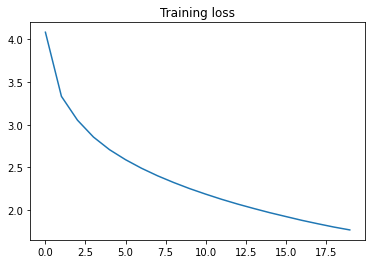

In [59]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.title("Training loss")

In [60]:
sos_idx = EN.vocab.stoi['<sos>']
eos_idx = EN.vocab.stoi['<eos>']

batch = next(iter(valid_iter))

for i in range(5):
    with torch.no_grad():
        encoder_input = batch.src[:, i].unsqueeze(1)
        hidden = enc.init_hidden(1)

        encoded = []
        for ip in encoder_input:
            encoded.append(DE.vocab.itos[ip.item()])

        out, hidden = enc(encoder_input, hidden)

        decoder_input = torch.tensor([sos_idx], device=device)

        decoded = []
        decoded.append(EN.vocab.itos[sos_idx])

        while True:
            output, hidden = dec(decoder_input, hidden)
            topv, topi = output.topk(1)
            decoder_input = topi.squeeze(1).detach()
            
            decoded.append(EN.vocab.itos[decoder_input.item()])
            if decoder_input.item() == eos_idx:
                break

        print(encoded)
        print(decoded)
        print()

['<sos>', 'Ein', 'Kind', 'sitzt', 'auf', 'einer', '<unk>', '.', '<eos>']
['<sos>', 'A', 'child', 'is', 'sitting', 'on', 'a', 'couch', '.', '<eos>']

['<sos>', 'Zwei', 'Frauen', 'lächeln', 'bei', 'einer', 'Veranstaltung', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'playing', 'a', 'game', 'of', 'checkers', 'to', '<unk>', 'a', 'jug', '.', '<eos>']

['<sos>', 'Zwei', 'Pudel', 'rennen', 'durch', 'den', 'Schnee', '.', '<eos>']
['<sos>', 'Two', 'basketball', 'players', 'jump', 'in', 'the', 'snow', '.', '<eos>']

['<sos>', '<unk>', '<unk>', 'tagsüber', 'ihre', '<unk>', '.', '<eos>', '<pad>']
['<sos>', '<unk>', 'are', 'being', '<unk>', 'by', 'the', 'ocean', '.', '<eos>']

['<sos>', 'Drei', 'Hunde', 'spielen', 'im', 'Wasser', '.', '<eos>', '<pad>']
['<sos>', 'Three', 'dogs', 'are', 'playing', 'in', 'the', 'water', '.', '<eos>']



In [ ]:
### Reversing the input (src) as suggested in the paper Sequence to Sequence Learning with Neural Networks
'''
Epoch 0 : Loss 4.116
Epoch 1 : Loss 3.334
Epoch 2 : Loss 3.012
Epoch 3 : Loss 2.796
Epoch 4 : Loss 2.644
Epoch 5 : Loss 2.523
Epoch 6 : Loss 2.421
Epoch 7 : Loss 2.331
Epoch 8 : Loss 2.250
Epoch 9 : Loss 2.179
Epoch 10 : Loss 2.112
Epoch 11 : Loss 2.053
Epoch 12 : Loss 1.997
Epoch 13 : Loss 1.944
Epoch 14 : Loss 1.897
Epoch 15 : Loss 1.852
Epoch 16 : Loss 1.808
Epoch 17 : Loss 1.768
Epoch 18 : Loss 1.732
Epoch 19 : Loss 1.696

['<sos>', '.', '<unk>', 'einer', 'auf', 'sitzt', 'Kind', 'Ein', '<eos>']
['<sos>', 'A', '<unk>', 'and', 'a', 'guy', 'getting', 'ready', 'to', 'put', 'a', '<unk>', '.', '<eos>']

['<sos>', '.', 'Veranstaltung', 'einer', 'bei', 'lächeln', 'Frauen', 'Zwei', '<eos>']
['<sos>', 'Five', 'road', 'people', 'are', 'playing', 'instruments', '.', '<eos>']

['<sos>', '.', 'Schnee', 'den', 'durch', 'rennen', 'Pudel', 'Zwei', '<eos>']
['<sos>', 'Five', 'water', 'racing', 'in', 'the', 'water', '.', '<eos>']

['<sos>', '.', '<unk>', 'ihre', 'tagsüber', '<unk>', '<unk>', '<eos>', '<pad>']
['<sos>', '<unk>', 'are', 'being', '<unk>', 'out', 'the', 'window', 'in', 'the', 'daytime', 'of', 'the', 'ocean', '.', '<eos>']

['<sos>', '.', 'Wasser', 'im', 'spielen', 'Hunde', 'Drei', '<eos>', '<pad>']
['<sos>', 'Five', 'men', '.', '<eos>']
'''